# meta-VQE

Hot to obtain a Potential Energy Surface (PES) plot without training for *all* the points of interest.

## Keypoints

* For a molecule, the Hamiltonian depends on the geometry (separation) of the atoms or nuclei
* For simple, vanilla VQE, all the possible configurations (separations) in the molecule need to be trained separately
* meta-VQE trains a few points (training points), encoding the original parameters $\vec{\theta}$ using metaparamers and a linear or Gaussian encoding.

The code below uses Catalyst (from Xanadu) and JAX to optimize calculations

In [1]:
import catalyst
from catalyst import qjit

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter, LogLocator

from scipy.optimize import minimize, OptimizeResult

import jax.numpy as jnp
from jax.core import ShapedArray

print(f"Pennylane {qml.__version__}")
print(f"Pennylane Catalyst {catalyst.__version__}")

np.random.seed(32)

# Import custom optimizers

from custom_optimizers import gradient_descent,spsa_optimizer,adam

Pennylane 0.31.0
Pennylane Catalyst 0.2.1


In [2]:
## Layers and wires for circuits

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

# Building the molecular hamiltonian for H2
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method="pyscf",
)
SHOTS = 1000 ## 1000, None. If none is used, the result is analytic

LAYERS = 2
WIRES = qubits

init_state = qml.qchem.hf_state(2, qubits)

## https://docs.pennylane.ai/projects/catalyst/en/latest/code/api/catalyst.grad.html - ["fd", "defer"]

TRAINERS = {"gradient_descent": 
            {"fun":gradient_descent, "options":{ 'maxiter': 150, 'tol':1e-5}},
            "spsa":{ "fun":spsa_optimizer, "options":{ 'maxiter': 150, 'tol':1e-5}},
            "adam":{"fun":adam, "options":{ 'maxiter': 150, 'tol':1e-5, 'demon':False}},
            "demon_adam":{"fun":adam, "options":{ 'maxiter': 150, 'tol':1e-5, 'demon':True}}}

GRADIENT_METHOD= "ps"

TRAINING_ENERGIES= {"gradient_descent":{
                        "meta":{"energies":[], "runs":0, "trained_vars":[], "energies_after_meta":[]},
                        "opt_meta":{"energies":[], "runs_per_step":[], "trained_vars":[]},
                        "vqe":{"energies":[], "runs_per_step":[], "trained_vars":[]}
                        },
                    "spsa":{
                        "meta":{"energies":[], "runs":0, "trained_vars":[], "energies_after_meta":[]},
                        "opt_meta":{"energies":[], "runs_per_step":[], "trained_vars":[]},
                        "vqe":{"energies":[], "runs_per_step":[], "trained_vars":[]}
                        },
                    "adam":{
                        "meta":{"energies":[], "runs":0, "trained_vars":[], "energies_after_meta":[]},
                        "opt_meta":{"energies":[], "runs_per_step":[], "trained_vars":[]},
                        "vqe":{"energies":[], "runs_per_step":[], "trained_vars":[]}
                        },
                    "demon_adam":{
                        "meta":{"energies":[], "runs":0, "trained_vars":[], "energies_after_meta":[]},
                        "opt_meta":{"energies":[], "runs_per_step":[], "trained_vars":[]},
                        "vqe":{"energies":[], "runs_per_step":[], "trained_vars":[]}
                        },

                   }

gradient_methods = {"fd":"finite-diff", "ps":"parameter-shift", "adj":"adjoint"}

# Encoder: 
# Linear -> 1
# Gaussian -> 2

ENCODER_MULTIPLIER_DICT = {1:2,
                      2:4}

ENCODER = 2

shared_dev = qml.device("lightning.qubit", wires=WIRES, shots=SHOTS)

train_points_indexes = [2,6,10,14,18]

test_points = np.arange(0.6,5,0.2)

train_points = np.array([test_points[i] for i in train_points_indexes])

test_hamiltonians = []

for d in test_points:
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, d]) 
    
    hamiltonian, _ = qml.qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        method="pyscf",
    )    
    
    test_hamiltonians.append(hamiltonian)
    
print("===== TRAIN POINTS =====")
print(train_points)

===== TRAIN POINTS =====
[1.  1.8 2.6 3.4 4.2]


In [3]:
## Get Full COnfiguration Integration (FCI) data to compare
## Notice there are several ways to run FCI in pyscf: https://pyscf.org/user/ci.html
import pyscf
fci_energies = []

for d in test_points:
    mol = pyscf.M(
    atom = 'H 0 0 0; H 0 0 {0}'.format(d),
    basis = 'sto3g',
    unit="Bohr",       charge= 0,
    spin= 0   , verbose = False
    )

    myhf = mol.RHF().run()

    cisolver = pyscf.fci.FCI(myhf)
    fci_energies.append(cisolver.kernel()[0])

### Linear Encoding

$\theta_{i} = w_{i} \, R + \phi_{i}$

In [4]:
def linear_encoding(param_array, r):
    """1-D array with alphas and betas. len(param_array) = 2 * len(weights) 

    Args:
        param_array (float): alphas and betas for lineasr encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """
    return param_array[::2]*r + param_array[1::2]

### Gaussian Encoding

$\theta_{i} = \alpha_{i} e^{\beta_{i} (\gamma_{i} - R)} + \delta_{i}$

In [5]:
def gaussian_encoding(param_array, r):
    """1-D array with alphas, betas, gammas and deltas. len(param_array) = 4 * len(weights) 

    Args:
        param_array (float): , betas, gammas and deltas for gaussian encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """

    exp_arg = param_array[1::4]*(param_array[2::4] - r)

    return param_array[::4]*jnp.exp(exp_arg) + param_array[3::4]

In [6]:
## Get shapes

## For linear is 2
## For Gaussian is 4
ENCODING_MULTIPLIER= ENCODER_MULTIPLIER_DICT[ENCODER]

if(ENCODER == 1):
    ENCODER_FUNC =linear_encoding
else:
    ENCODER_FUNC =gaussian_encoding

shape = qml.kUpCCGSD.shape(k=LAYERS, n_wires=WIRES, delta_sz=0)

num_params = (LAYERS*shape[1])


num_params_encoding = num_params*ENCODING_MULTIPLIER

weights = np.random.random(num_params_encoding)

print("===== NUM OF PARAMETERS =====")
print(num_params_encoding)

===== NUM OF PARAMETERS =====
48


In [7]:
##Run for all points without training

@qml.qnode(shared_dev, diff_method= gradient_methods[GRADIENT_METHOD])
def kUpCCGSD_pennylane(params, hamiltonian):

    shape = qml.kUpCCGSD.shape(k=LAYERS, n_wires=WIRES, delta_sz=0)

    weights = np.reshape(params,shape)

    qml.kUpCCGSD(weights=weights, wires=range(WIRES), k = LAYERS,init_state=init_state)

    return qml.expval(
        qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
    )  

### Cost Function

Sum of energies for each configuration (separation)

$C(\vec{\theta}) = \sum_{i=1}^{M} \bra{\psi_{i}} \hat{H}(\vec{\lambda}_{i}) \ket{\psi_{i}}$


In [8]:
@qjit
def energy_kUpCCGSD(params: ShapedArray(shape=(num_params_encoding,), dtype=jnp.float64)):

    energies = []  
    gradients = []  

    for r in train_points:
   
        def kUpCCGSD_pennylane(params):
        
            coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])     
            
            # Building the molecular hamiltonian for H2
            hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
                symbols,
                coordinates,
                method="pyscf",
            )
            
            
            shape = qml.kUpCCGSD.shape(k=LAYERS, n_wires=qubits, delta_sz=0) 

            weights_encoded =  ENCODER_FUNC(params, r)       

            weights = np.reshape(weights_encoded,shape)

            qml.kUpCCGSD(weights=weights, wires=range(qubits), k = LAYERS,init_state=init_state)

            return qml.expval(
                qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
            )  
                
        circuit = qml.QNode(kUpCCGSD_pennylane, shared_dev, diff_method= gradient_methods[GRADIENT_METHOD])
        
        energies.append(circuit(params))
        gradients.append(catalyst.grad(circuit, method = "defer" )(params))
        
    join_energy = jnp.sum(jnp.array(energies))

        
    all_gradients = jnp.array(gradients)
    joined_gradients = jnp.sum(jnp.array([all_gradients[i][0] for i in range(len(all_gradients))]), axis=0)    


    
    return join_energy/len(train_points) , joined_gradients/len(train_points)

In [9]:
for train_method in TRAINERS:

    params_run = np.random.random(num_params_encoding)

    res_train = minimize(energy_kUpCCGSD, params_run, method = TRAINERS[train_method]["fun"], options = TRAINERS[train_method]["options"])

    TRAINING_ENERGIES[train_method]["meta"]["trained_vars"] = res_train.x
    TRAINING_ENERGIES[train_method]["meta"]["energies"].append(res_train.fun)
    TRAINING_ENERGIES[train_method]["meta"]["runs"] = res_train.nit

Finished Gradient Descent training
Finished SPSA training
Finished ADAM training
Finished ADAM training


<function matplotlib.pyplot.show(close=None, block=None)>

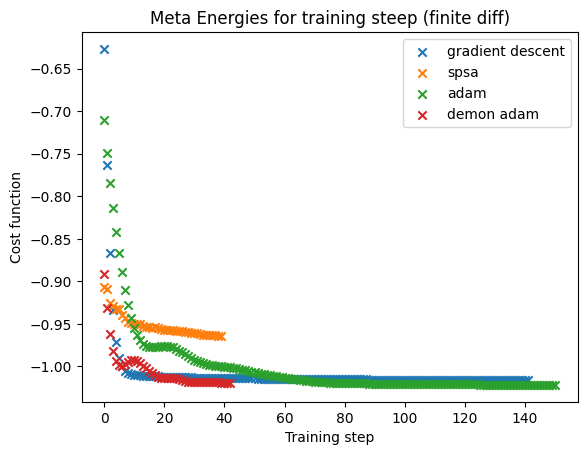

In [10]:
plt.scatter([i for i in range(len(TRAINING_ENERGIES['gradient_descent']["meta"]['energies'][-1]))],TRAINING_ENERGIES['gradient_descent']["meta"]['energies'][-1], label="gradient descent", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['spsa']["meta"]['energies'][-1]))],TRAINING_ENERGIES['spsa']["meta"]['energies'][-1], label="spsa", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['adam']["meta"]['energies'][-1]))],TRAINING_ENERGIES['adam']["meta"]['energies'][-1], label="adam", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['demon_adam']["meta"]['energies'][-1]))],TRAINING_ENERGIES['demon_adam']["meta"]['energies'][-1], label="demon adam", marker='x')

plt.legend()
plt.title('Meta Energies for training steep (finite diff)')
plt.ylabel('Cost function')
plt.xlabel('Training step')
plt.show

In [11]:
for count, d in enumerate(test_points):
    for train_method in TRAINERS:
        if ENCODER == 1:
            encoded_params = linear_encoding(TRAINING_ENERGIES[train_method]["meta"]["trained_vars"], d)
        else:
            encoded_params = gaussian_encoding(TRAINING_ENERGIES[train_method]["meta"]["trained_vars"], d)
        TRAINING_ENERGIES[train_method]["meta"]["energies_after_meta"].append(kUpCCGSD_pennylane(encoded_params,test_hamiltonians[count]))

/opt/conda/envs/python39/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


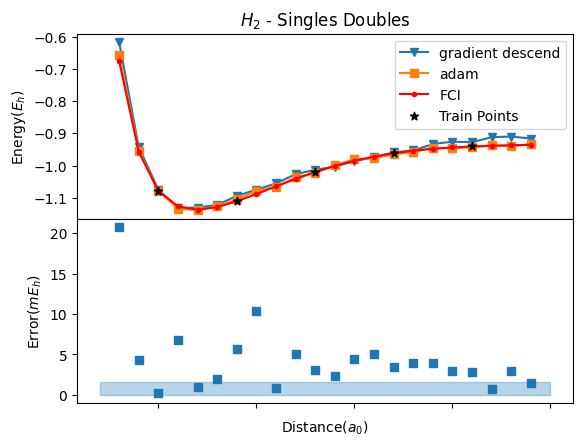

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

plt.subplots_adjust(hspace=0)

# ax1.plot(test_points, grad_descent_energies, label="gradient_descent", marker='s' , color=colors[0])
# ax1.plot(test_points, spsa_energies, label="spsa", marker='o', color=colors[1])
ax1.plot(test_points, TRAINING_ENERGIES["gradient_descent"]["meta"]["energies_after_meta"], label="gradient descend", marker='v',)
ax1.plot(test_points, TRAINING_ENERGIES["adam"]["meta"]["energies_after_meta"], label="adam", marker='s', )
ax1.plot(test_points, fci_energies, label="FCI", marker='.', color="r")
ax1.scatter(train_points, [fci_energies[i] for i in train_points_indexes], zorder=99, label="Train Points", marker='*', color="black")


ax1.legend()
ax1.set_title('$H_{2}$ - Singles Doubles')
ax1.set_ylabel('Energy($E_{h}$)')

# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(grad_descent_energies ,fci_energies)], label="gradient_descent", marker='s', color=colors[0])
# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(adam_energies ,fci_energies)], label="adam", marker='v', color=colors[2])
# ax2.scatter(test_points, [np.abs(i-j) for i,j in zip(trained_energies["gradient_descent"] ,fci_energies)], label="adam", marker='v')
ax2.scatter(test_points, [np.abs(i-j)*1000 for i,j in zip(TRAINING_ENERGIES["adam"]["meta"]["energies_after_meta"] ,fci_energies)], label="adam", marker='s')


ax1.sharex(ax2)
ax1.set_xticklabels([])
ax2.autoscale() ## call autoscale if needed
ax2.fill_between([test_points[0]-0.2,test_points[-1]+0.2],1.6, color="#1f77b450")

# ax2.set_title('Error for each point')
ax2.set_xlabel('Distance($a_{0}$)')
ax2.set_ylabel('Error($mE_{h}$)')


plt.show()

In [13]:
for count, work_hamiltonian in enumerate(test_hamiltonians):

    @qjit
    def energy_kUpCCGSD(params: ShapedArray(shape=(num_params,), dtype=jnp.float64)):
   
        def kUpCCGSD_pennylane(params):                
            
            shape = qml.kUpCCGSD.shape(k=LAYERS, n_wires=WIRES, delta_sz=0) 

            weights = np.reshape(params,shape)

            qml.kUpCCGSD(weights=weights, wires=range(WIRES), k = LAYERS,init_state=init_state)

            return qml.expval(
                qml.Hamiltonian(np.array(work_hamiltonian.coeffs), work_hamiltonian.ops)
            )  
                
        circuit = qml.QNode(kUpCCGSD_pennylane, shared_dev,diff_method= gradient_methods[GRADIENT_METHOD])
        
        return circuit(params) , catalyst.grad(circuit, method = "defer" )(params)


    if ENCODER == 1:
        init_params_run = linear_encoding(np.array(TRAINING_ENERGIES[train_method]["meta"]["trained_vars"]), test_points[count])
    else:
        init_params_run = gaussian_encoding(np.array(TRAINING_ENERGIES[train_method]["meta"]["trained_vars"]), test_points[count])

    for train_method in TRAINERS:

        res_train = minimize(energy_kUpCCGSD, init_params_run, method = TRAINERS[train_method]["fun"], options = TRAINERS[train_method]["options"])

        TRAINING_ENERGIES[train_method]["opt_meta"]["trained_vars"].append(res_train.x)  
        TRAINING_ENERGIES[train_method]["opt_meta"]["energies"].append(res_train.fun)
        TRAINING_ENERGIES[train_method]["opt_meta"]["runs_per_step"].append(res_train.nit) 

        if(count == 0):
            params_run = np.random.random(num_params)
        else:
            params_run = TRAINING_ENERGIES[train_method]["vqe"]["trained_vars"][-1]

        res_train_vqe = minimize(energy_kUpCCGSD, params_run, method = TRAINERS[train_method]["fun"], options = TRAINERS[train_method]["options"])

        TRAINING_ENERGIES[train_method]["vqe"]["trained_vars"].append(res_train_vqe.x)  
        TRAINING_ENERGIES[train_method]["vqe"]["energies"].append(res_train_vqe.fun)
        TRAINING_ENERGIES[train_method]["vqe"]["runs_per_step"].append(res_train_vqe.nit)      

Finished Gradient Descent training
Finished Gradient Descent training
Finished SPSA training
Finished SPSA training
Finished ADAM training
Finished ADAM training
Finished ADAM training
Finished ADAM training
Finished Gradient Descent training
Finished Gradient Descent training
Finished SPSA training
Finished SPSA training
Finished ADAM training
Finished ADAM training
Finished ADAM training
Finished ADAM training
Finished Gradient Descent training
Finished Gradient Descent training
Finished SPSA training
Finished SPSA training
Finished ADAM training
Finished ADAM training
Finished ADAM training
Finished ADAM training
Finished Gradient Descent training
Finished Gradient Descent training
Finished SPSA training
Finished SPSA training
Finished ADAM training
Finished ADAM training
Finished ADAM training
Finished ADAM training
Finished Gradient Descent training
Finished Gradient Descent training
Finished SPSA training
Finished SPSA training
Finished ADAM training
Finished ADAM training
Finish

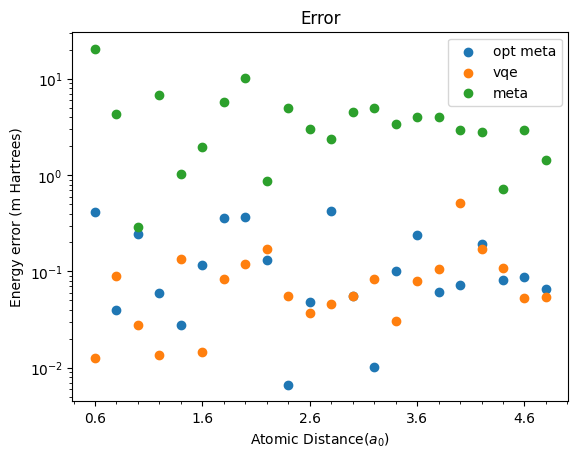

In [14]:
fig, ax = plt.subplots()

# Plot for errors
ax.scatter(test_points,[np.abs(i-j)*1000 for i,j in zip([energy[-1] for energy in TRAINING_ENERGIES["adam"]["opt_meta"]["energies"]],fci_energies)], label="opt meta", marker='o')
ax.scatter(test_points,[np.abs(i-j)*1000 for i,j in zip([energy[-1] for energy in TRAINING_ENERGIES["adam"]["vqe"]["energies"]],fci_energies)], label="vqe", marker='o')
ax.scatter(test_points,[np.abs(i-j)*1000 for i,j in zip(TRAINING_ENERGIES["adam"]["meta"]["energies_after_meta"],fci_energies)], label="meta", marker='o')


ax.legend()
ax.set_title('Error')
ax.set_yscale('log',base=10) 
ax.set_ylabel('Energy error (m Hartrees)')
ax.set_xlabel('Atomic Distance($a_{0}$)')


ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_xticks(np.arange(min(test_points), max(test_points)+0.2, 1))

In [15]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray) or isinstance(obj, jnp.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
with open(f'exp_runs/kupccgsd_{LAYERS}layers_{GRADIENT_METHOD}.json', 'w') as f:
    f.write(json.dumps({
        "layers": LAYERS,
        "results": TRAINING_ENERGIES
    }
    , indent=4, cls=NumpyEncoder)) 